In [14]:
!pip -q install wfdb
import random

import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.signal
from collections import Counter, OrderedDict


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
mit_dir=r'D:\PyProjects\arryth_mit'
data_dir=r'D:\PyProjects\arryth_data'
# file_with_files_to_read='RECORDS_GOOD'
file_with_files_to_read='RECORDS'
label_desc= {'!': ['Ventricular flatter wave',      [0,0,0,0,0,0,0,0,0,0,0,0,1]], 
             '+':['Rhytm change',                   [0,0,0,0,0,0,0,0,0,0,0,1,0]],
             'A':['Atrial premature contraction',   [0,0,0,0,0,0,0,0,0,0,1,0,0]],
             'E':['Ventricular escape beat',        [0,0,0,0,0,0,0,0,0,1,0,0,0]],
             'F':['Fusion of vetricular and normal beat', [0,0,0,0,0,0,0,0,1,0,0,0,0]],
             'L':['Left bundle branch block beat',  [0,0,0,0,0,0,0,1,0,0,0,0,0]],
             'N':['Normal beat',                    [0,0,0,0,0,0,1,0,0,0,0,0,0]], 
             'R':['Right bundle branch block beat', [0,0,0,0,0,1,0,0,0,0,0,0,0]],
             'V':['Prematural ventricular contraction',[0,0,0,0,1,0,0,0,0,0,0,0,0]], 
             'a':['Aberrated atrial premature beat',[0,0,0,1,0,0,0,0,0,0,0,0,0]], 
             'j':['Nodal (junctional) escape beat', [0,0,1,0,0,0,0,0,0,0,0,0,0]],
             'x':['Non-conducted P-wave (blocked APB)',[0,1,0,0,0,0,0,0,0,0,0,0,0]],
             '~':['Signal quality change',          [1,0,0,0,0,0,0,0,0,0,0,0,0]],}
    #        '/': 'Pased beat',
      #      'f' : 'Fusion of normal and paced beat'
        #    '!' : 'Ventrical flutter wave',
         #   'x' : 'Non-conducted P-wave'
allowed_labels=list(label_desc.keys())
desired_signal_length=256

In [18]:
class Pan_Tompkins_QRS():
  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    Bandpass filter is used to attenuate the noise in the input signal.
    To acheive a passband of 5-15 Hz, the input signal is first passed
    through a low pass filter having a cutoff frequency of 11 Hz and then
    through a high pass filter with a cutoff frequency of 5 Hz, thus
    achieving the required thresholds.

    The low pass filter has the recursive equation:
      y(nT) = 2y(nT - T) - y(nT - 2T) + x(nT) - 2x(nT - 6T) + x(nT - 12T)

    The high pass filter has the recursive equation:
      y(nT) = 32x(nT - 16T) - y(nT - T) - x(nT) + x(nT - 32T)
    '''

    result = None
    sig = signal.copy()

    # Apply the low pass filter using the equation given
    for index in range(len(signal)):
      sig[index] = signal[index]

      if (index >= 1):
        sig[index] += 2*sig[index-1]
      if (index >= 2):
        sig[index] -= sig[index-2]
      if (index >= 6):
        sig[index] -= 2*signal[index-6]
      if (index >= 12):
        sig[index] += signal[index-12]

    # Copy the result of the low pass filter
    result = sig.copy()

    # Apply the high pass filter using the equation given
    for index in range(len(signal)):
      result[index] = -1*sig[index]
      if (index >= 1):
        result[index] -= result[index-1]
      if (index >= 16):
        result[index] += 32*sig[index-16]
      if (index >= 32):
        result[index] += sig[index-32]

    # Normalize the result from the high pass filter
    max_val = max(max(result),-min(result))
    result = result/max_val

    return result

  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The peak detection algorithm works on the moving window and bandpass
    filtered signal. So the input signal is first bandpassed, then the
    output of the bandpass filter is given to the derivative function and
    the result is squared. Finally the output of the squaring function
    is given to the moving window integration function and returned.
    '''

    # Convert the input signal into numpy array
    input_signal = signal.iloc[:,1].to_numpy()

    # Bandpass Filter
    bpass = self.band_pass_filter(input_signal.copy())
    return input_signal, bpass

In [53]:
class DataProcessor():
    _data_directory=0
    _file_with_files_to_read=0
    _max_load_files=0
    _allowed_labels=0
    _desired_signal_length=512
    def __init__(self,data_directory, file_with_files_to_read, max_load_files, allowed_labels, desired_signal_length):
        self._data_directory=data_directory
        self._file_with_files_to_read=file_with_files_to_read
        self._max_load_files=max_load_files
        self._allowed_labels=allowed_labels
        self._desired_signal_length=desired_signal_length
    def resample_fft(self, signal):
        resampled_signal = scipy.signal.resample(signal, self._desired_signal_length)
        return resampled_signal
    def resample_fft_symm(self, signal):
        resampled_signal = scipy.signal.resample(signal, self._desired_signal_length)
        return resampled_signal
    def resample_poly(self, signal):
        resampled_signal = scipy.signal.resample_poly(signal, self._desired_signal_length, len(signal))
        return resampled_signal
    def get_episodes(self, cur_annotation, input_signal, input_signal1, bpass, bpass1):
        episodes_input=list()
        episodes_input1=list()
        episodes_bpass=list()
        episodes_bpass1=list()
        episodes_labels=list()
        episodes_spike=list()
        bpass_offset=20
        n_symbol_counter=0
        max_episodes=len(cur_annotation.symbol)-2
        for i in range(2, max_episodes):
            #cur_label=cur_annotation.symbol[i].strip()
            #cur_label= ''.join(cur_annotation.symbol[i].split())
            cur_label= cur_annotation.symbol[i]
            if cur_label in self._allowed_labels:
                if cur_label=='N':
                    if n_symbol_counter<5:
                        n_symbol_counter+=1
                        continue
                    else:
                        n_symbol_counter=0
                spike_pos=cur_annotation.sample[i]
                previous_spike=cur_annotation.sample[i-1]
                next_spike=cur_annotation.sample[i+1]
                episode_start_pos=spike_pos-(spike_pos-previous_spike)//2
                episode_end_pos=spike_pos+(next_spike-spike_pos)//2
                episode_lenght=episode_end_pos-episode_start_pos
                #print(f'Эпизод {i} of {max_episodes}: Символ=_{cur_annotation.symbol[i]}_ длина эпизода:{episode_lenght}')
                episodes_input.append(input_signal[episode_start_pos:episode_end_pos])
                episodes_input1.append(input_signal1[episode_start_pos:episode_end_pos])
                episodes_bpass.append(bpass[episode_start_pos+bpass_offset:episode_end_pos+bpass_offset])
                episodes_bpass1.append(bpass1[episode_start_pos+bpass_offset:episode_end_pos+bpass_offset])
                episodes_spike.append(spike_pos-episode_start_pos)
                episodes_labels.append(cur_label)
            #else:
                # print(f'Пропускаем эпизод, символ=_{cur_annotation.symbol[i]}_')
        print(f'Загружены эпизоды: {sorted(Counter(episodes_labels).items())}')
        return episodes_input, episodes_input1, episodes_bpass, episodes_bpass1, episodes_spike, episodes_labels
    def load(self):
        input_episodes0_raw=list()
        input_episodes0_bpass=list()
        input_episodes1_raw=list()
        input_episodes1_bpass=list()
        input_episodes_spikes=list()
        input_episodes_labels=list()

        records_filename = f"{self._data_directory}/{self._file_with_files_to_read}"
        with open(records_filename) as f:
            records_to_read = f.read().split('\n')
        records_to_read_list=records_to_read[:len(records_to_read)-1]
        counter=0
        QRS_detector = Pan_Tompkins_QRS()
        for fname in records_to_read_list:
            filename=f'{self._data_directory}/{fname}'
            print(f'Обрабатывается файл "{fname}", файл #{counter+1} из {len(records_to_read_list)}')

            record = wfdb.rdrecord(filename)

            ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T,columns=['TimeStamp','ecg'])
            input_signal, bpass  = QRS_detector.solve(ecg)
            #input_signals.append(input_signal)
            #bpass_signals.append(bpass)

            ecg1 = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,1]]).T,columns=['TimeStamp','ecg'])
            input_signal1, bpass1  = QRS_detector.solve(ecg1)
            #input_signals1.append(input_signal1)
            #bpass_signals1.append(bpass1)

            annotation = wfdb.rdann(filename, 'atr', shift_samps=True)
            ### Разбиваем все на эпизоды
            episodes_input0, episodes_input1, episodes_bpass0, episodes_bpass1, episodes_spike, episodes_labels = self.get_episodes( annotation, input_signal, input_signal1, bpass, bpass1)

            input_episodes0_raw  += [self.resample_fft(episodes_input0[i]) for i in range(0, len(episodes_input0))]
            input_episodes0_bpass+= [self.resample_fft(episodes_bpass0[i]) for i in range(0, len(episodes_bpass0))]
            input_episodes1_raw  += [self.resample_fft(episodes_input1[i]) for i in range(0, len(episodes_input1))]
            input_episodes1_bpass+= [self.resample_fft(episodes_bpass1[i]) for i in range(0, len(episodes_bpass1))]

            input_episodes_spikes+=[f'{episodes_spike[i]}' for i in range(0, len(episodes_spike))]

            input_episodes_labels+=[episodes_labels[i] for i in range(0, len(episodes_labels))]

            if counter==self._max_load_files-1:
                break;
            counter+=1
        print('Обработка завершена! Анализ количества различных эпизодов в выборке:')
        print(sorted(Counter(input_episodes_labels).items()))
        return input_episodes0_raw, input_episodes1_raw, input_episodes0_bpass, input_episodes1_bpass, input_episodes_spikes, input_episodes_labels

In [54]:
data_proc=DataProcessor(data_directory=mit_dir, file_with_files_to_read=file_with_files_to_read, max_load_files=49, allowed_labels=allowed_labels, desired_signal_length=desired_signal_length)

In [55]:
input_episodes0_raw, input_episodes1_raw, input_episodes0_bpass, input_episodes1_bpass, input_episodes_spikes, input_episodes_labels = data_proc.load()
# | - 34 + 43 V 561 /q-7 N -5893

Обрабатывается файл "100", файл #1 из 48
Загружены эпизоды: [('A', 33), ('N', 372), ('V', 1)]
Обрабатывается файл "101", файл #2 из 48
Загружены эпизоды: [('A', 3), ('N', 309), ('~', 4)]
Обрабатывается файл "102", файл #3 из 48
Загружены эпизоды: [('+', 4), ('N', 16), ('V', 4)]
Обрабатывается файл "103", файл #4 из 48
Загружены эпизоды: [('A', 2), ('N', 346), ('~', 6)]
Обрабатывается файл "104", файл #5 из 48
Загружены эпизоды: [('+', 44), ('N', 27), ('V', 2), ('~', 37)]
Обрабатывается файл "105", файл #6 из 48
Загружены эпизоды: [('N', 420), ('V', 41), ('~', 88)]
Обрабатывается файл "106", файл #7 из 48
Загружены эпизоды: [('+', 40), ('N', 251), ('V', 519), ('~', 29)]
Обрабатывается файл "107", файл #8 из 48
Загружены эпизоды: [('V', 59), ('~', 2)]
Обрабатывается файл "108", файл #9 из 48
Загружены эпизоды: [('A', 4), ('F', 2), ('N', 289), ('V', 17), ('j', 1), ('x', 11), ('~', 41)]
Обрабатывается файл "109", файл #10 из 48
Загружены эпизоды: [('F', 2), ('L', 2489), ('V', 38), ('~', 2)

In [29]:
import random
#len(input_episodes0_raw)
print(type(input_episodes0_raw[0]))
print(input_episodes0_raw[3].shape)
print(random.randint(0,1000))

926

Text(0.5, 0.98, 'Образцы нарезанных кадров')

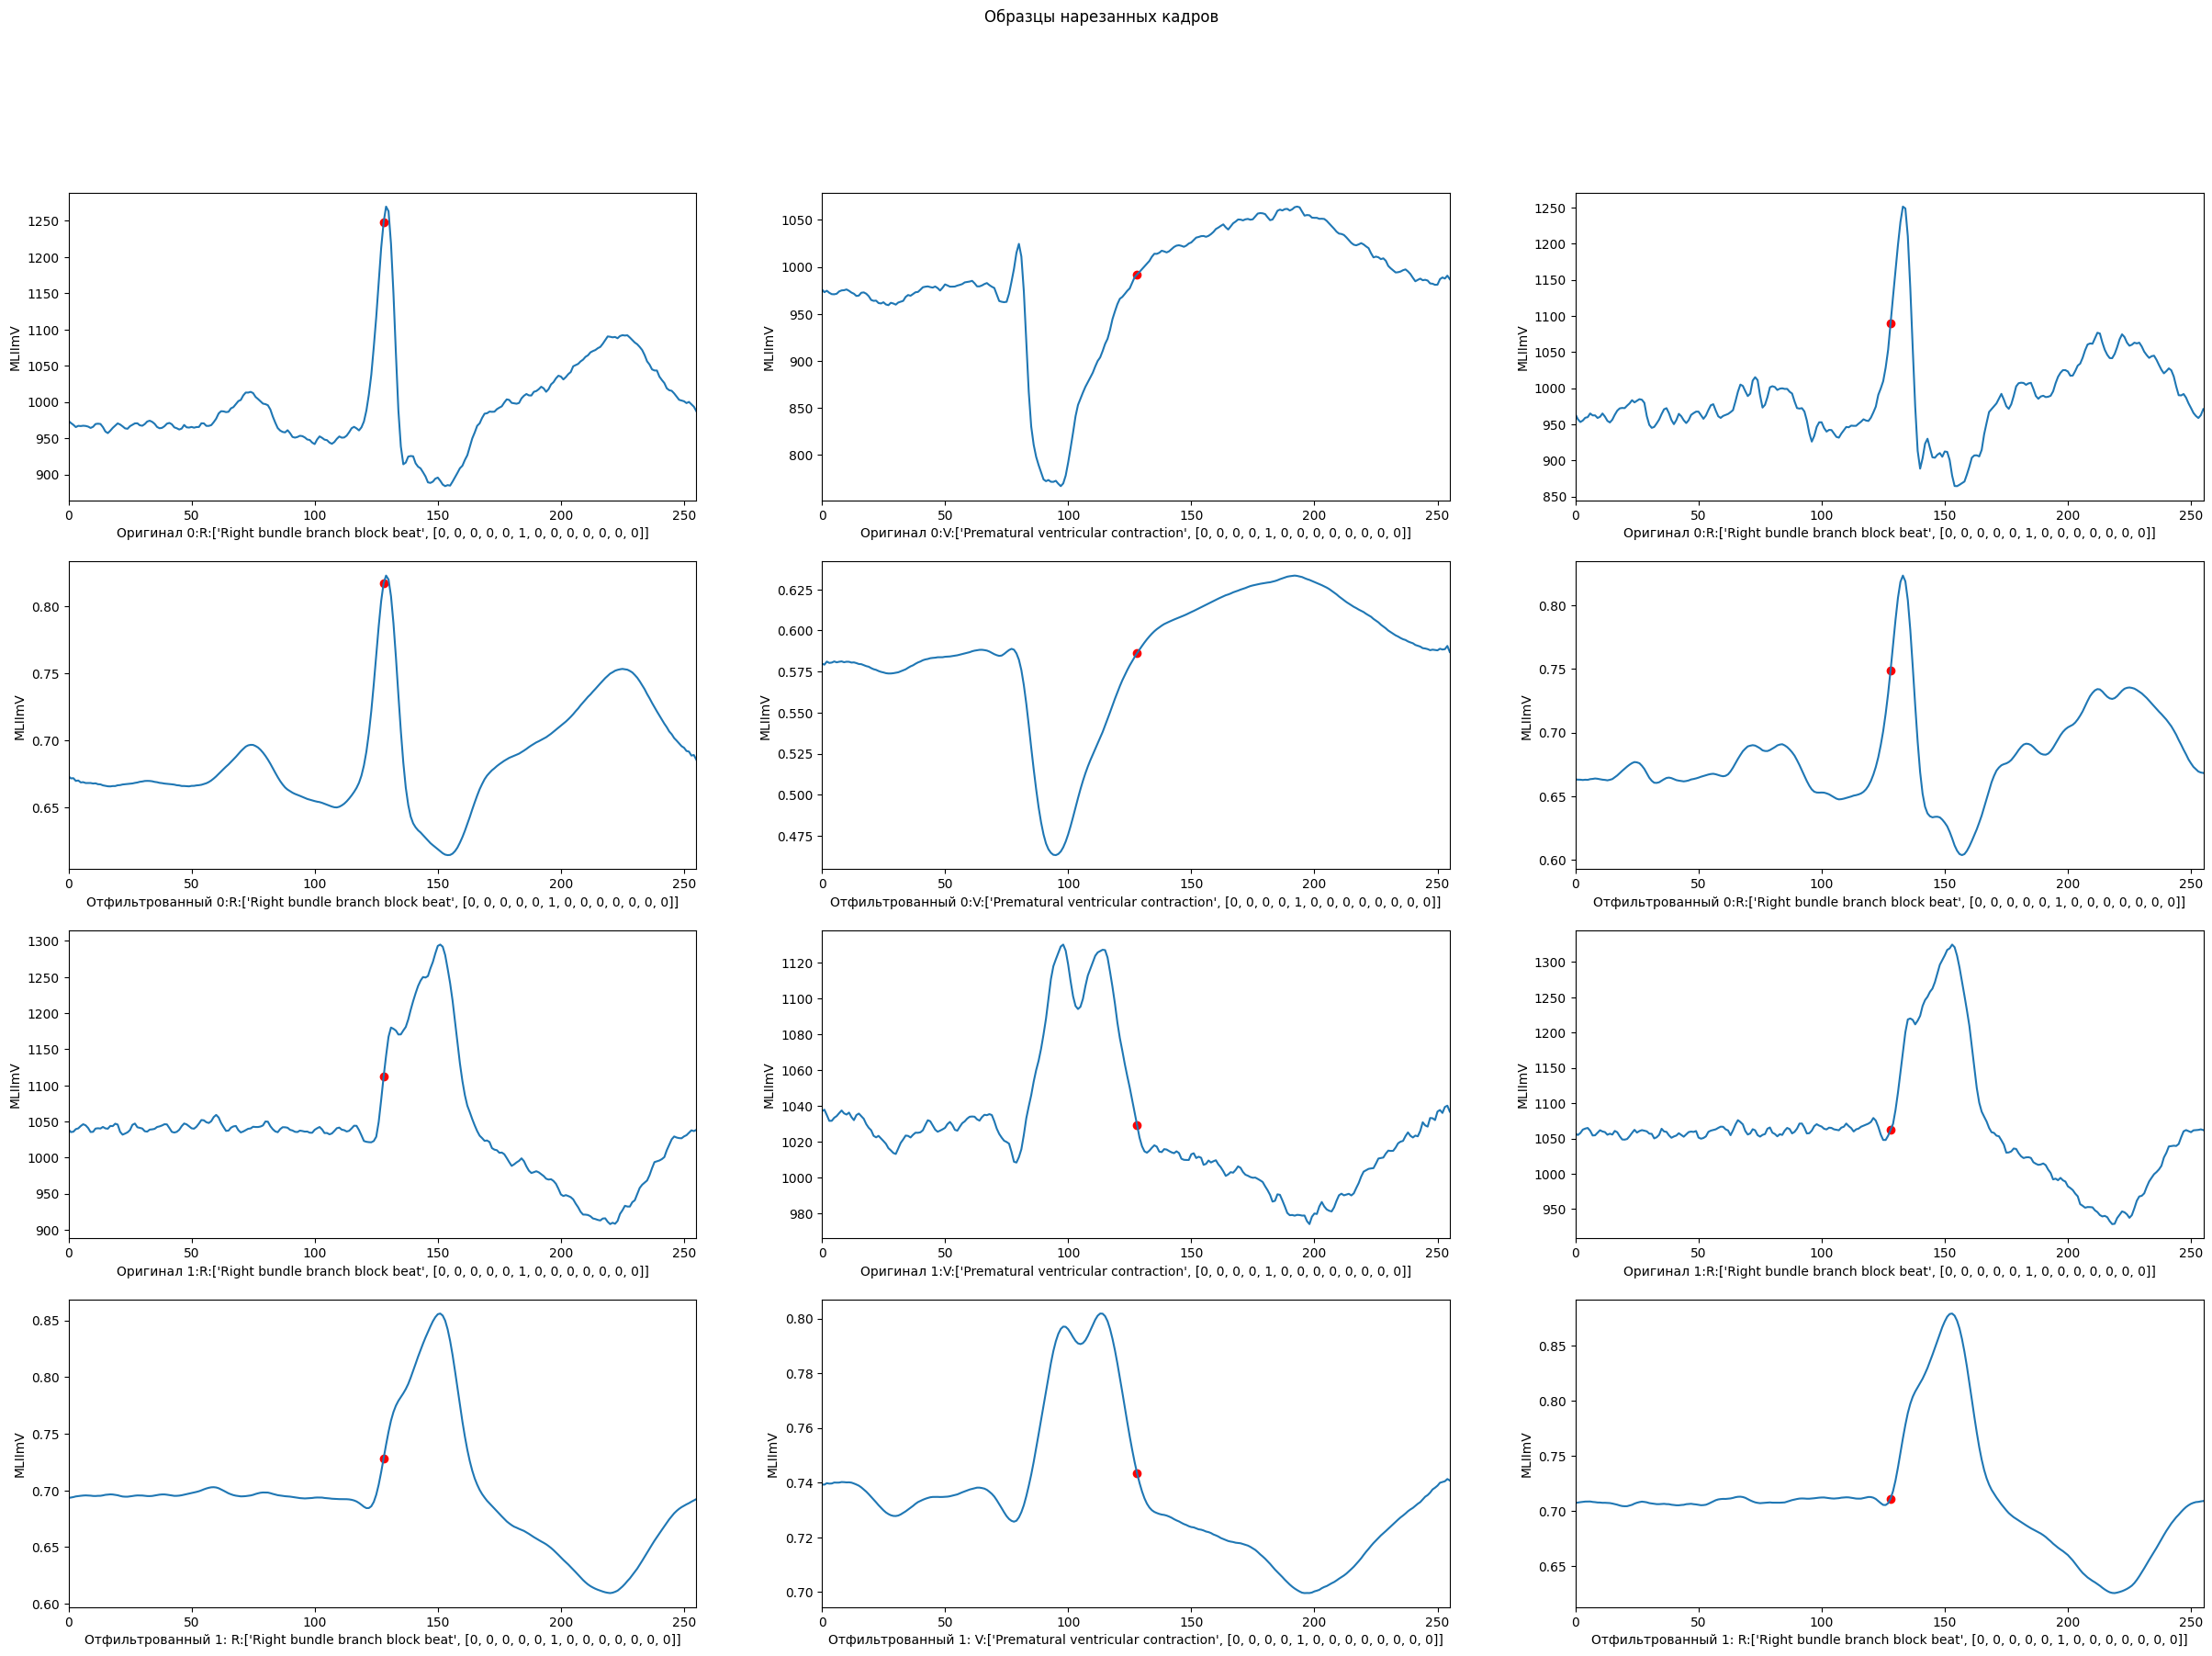

In [30]:
#win_index=[3, 20,117]
max_number=len(input_episodes_spikes)-20
win_index=[random.randint(0,max_number),random.randint(0,max_number),random.randint(0,max_number)]
fig, axs = plt.subplots(4, 3, figsize=(30, 20))
#plt.figure(figsize = (4,3), dpi = 100)
#plt.xticks(np.arange(start_pos, end_pos, 30))
for i in range(0, len(win_index)):
    desc=f'{input_episodes_labels[win_index[i]]}:{label_desc.get(input_episodes_labels[win_index[i]])}'
    index=win_index[i]
    spike_x=desired_signal_length//2 #int(input_episodes_spikes[index])
    axs[0,i].plot(input_episodes0_raw[index])
    axs[0,i].set_xlim(0, desired_signal_length-1)
    #spike_x=input_episodes_spikes[index]
    spike_y=input_episodes0_raw[index][spike_x]
    axs[0,i].scatter(spike_x, spike_y, marker='o', color='r', label='point')
    axs[0,i].set_xlabel(f'Оригинал 0:{desc}')
    axs[0,i].set_ylabel('MLIImV')

    axs[1,i].plot(input_episodes0_bpass[index])
    axs[1,i].set_xlim(0, desired_signal_length-1)
    #spike_x=input_episodes_spikes[index]
    spike_y=input_episodes0_bpass[index][spike_x]
    axs[1,i].scatter(spike_x, spike_y, marker='o', color='r', label='point')
    axs[1,i].set_xlabel(f'Отфильтрованный 0:{desc}')
    axs[1,i].set_ylabel('MLIImV')

    axs[2,i].plot(input_episodes1_raw[index])
    axs[2,i].set_xlim(0, desired_signal_length-1)
    #spike_x=input_episodes_spikes[index]
    spike_y=input_episodes1_raw[index][spike_x]
    axs[2,i].scatter(spike_x, spike_y, marker='o', color='r', label='point')
    axs[2,i].set_xlabel(f'Оригинал 1:{desc}')
    axs[2,i].set_ylabel('MLIImV')

    axs[3,i].plot(input_episodes1_bpass[index])
    axs[3,i].set_xlim(0, desired_signal_length-1)
    #spike_x=input_episodes_spikes[index]
    spike_y=input_episodes1_bpass[index][spike_x]
    axs[3,i].scatter(spike_x, spike_y, marker='o', color='r', label='point')
    axs[3,i].set_xlabel(f'Отфильтрованный 1: {desc}')
    axs[3,i].set_ylabel('MLIImV')

fig.suptitle("Образцы нарезанных кадров")

In [31]:
label_encoded=[label_desc[label][1] for label in input_episodes_labels]

In [32]:
label_encoded[0:5]

[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]

In [33]:
dict = {'label': input_episodes_labels, 'label_encoded':label_encoded, 'bpass0': input_episodes0_bpass, 'bpass1': input_episodes1_bpass}
df = pd.DataFrame(dict)
df = df.reset_index()

In [34]:
df["index1"]=df["index"]

In [35]:
df.columns

Index(['index', 'label', 'label_encoded', 'bpass0', 'bpass1', 'index1'], dtype='object')

In [36]:
df["label"].value_counts()

label
N    10271
L     8066
R     5601
V     5456
A      870
F      777
+      753
~      524
!      472
x      190
a      149
E      106
j       16
Name: count, dtype: int64

In [37]:
d_df=df[['index1','label']].loc[df['label']=='N']

In [38]:
d_df.columns

Index(['index1', 'label'], dtype='object')

In [39]:
d_df["label"].value_counts()

label
N    10271
Name: count, dtype: int64

In [40]:
d_df.iloc[25000]

IndexError: single positional indexer is out-of-bounds

In [41]:
print(d_df[d_df.index==135]['index1'])
print(type(int(d_df[d_df.index==135]['index1'])))

135    135
Name: index1, dtype: int64
<class 'int'>


C:\Users\s.kramorov\AppData\Local\Temp\ipykernel_7172\746844686.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(type(int(d_df[d_df.index==135]['index1'])))


In [44]:
n_episondes_number=d_df.shape[0]
print(f'Создаем список для удаления излишнего количества данных с лейблом N. Всего таких записей {n_episondes_number}, оставим 10000')
index_to_delete=list()
for i in range(0, n_episondes_number-10000):
    updated=False
    while (not updated):
        new_index_to_delete=random.randint(0,n_episondes_number)
        if new_index_to_delete not in index_to_delete:
            index_to_delete.append(new_index_to_delete)
            updated = True
print(f'Создание списка завершено. Размер списка индексов на удаление {len(index_to_delete)}.')

Создаем список для удаления излишнего количества данных с лейблом N. Всего таких записей 10271, оставим 10000
Создание списка завершено. Размер списка индексов на удаление 271.


In [45]:
input_episodes_labels[index_to_delete[1]]

'L'

In [46]:
df1 = df.query("index1 != @index_to_delete")
#df.loc[df["index1" not in index_to_delete]]


In [47]:
df1 = df.query('index1.isin(@index_to_delete)')

In [48]:
df1["label"].value_counts()

label
L    127
N    106
V     22
R      6
~      6
+      3
A      1
Name: count, dtype: int64

In [49]:
for row_delete in index_to_delete:
    df.drop("index1" == row_delete, axis=0, inplace = True)

KeyError: '[False] not found in axis'

In [81]:
df["label"].value_counts()

label
N    27013
V     2872
R     2270
A     1874
L     1224
+      636
j      215
~      190
x      143
F      140
!       75
a       26
E       11
Name: count, dtype: int64

In [45]:
df1= df.query("index not in index_to_delete")

UndefinedVariableError: name 'index_to_delete' is not defined

In [53]:
df.loc[df['label']=='N'].count()

index     26996
label     26996
bpass0    26996
bpass1    26996
dtype: int64

In [15]:
data_fname=f'{data_dir}\{"file1"}'
df.to_hdf(data_fname, key='df', mode='w', )

C:\Users\kramorov.s\AppData\Local\Temp\ipykernel_11072\1756123774.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['label', 'label_encoded', 'bpass0', 'bpass1'], dtype='object')]

  df.to_hdf(data_fname, key='df', mode='w', )


In [16]:
df1=pd.read_hdf(data_fname, key='df', errors="strict")

In [17]:
df1

,index,label,label_encoded,bpass0,bpass1
0,0,N,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0.6441496073887246, 0.6441128763674354, 0.644...","[0.8567249206182584, 0.8557453764940929, 0.854..."
1,1,N,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0.6623043617894746, 0.661890846911486, 0.6623...","[0.8585580483597541, 0.8566673951089603, 0.856..."
2,2,N,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0.6638556252263271, 0.6661189733708209, 0.665...","[0.8682242306182099, 0.869536560738515, 0.8689..."
3,3,N,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0.6564951893785141, 0.6566179266181936, 0.656...","[0.8579296116960399, 0.8574118622770817, 0.857..."
4,4,N,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0.6788270818927681, 0.6779348163657469, 0.678...","[0.8687936163827528, 0.8695390191092227, 0.869..."
...,...,...,...,...,...
37553,37553,N,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0.6244641826382437, 0.6242753369537347, 0.624...","[0.8733257362751897, 0.8738146351486261, 0.873..."
37554,37554,N,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0.6091571727234751, 0.6086187572892056, 0.608...","[0.8637282467402316, 0.8635496057572899, 0.863..."
37555,37555,N,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0.6019213532566724, 0.6020585800040478, 0.603...","[0.8639429877053636, 0.8644417660274942, 0.865..."
37556,37556,N,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0.6186675500474736, 0.6182107060625278, 0.618...","[0.8628220398673752, 0.862232972460855, 0.8619..."
